#Connect to Personal Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Necessary Packages 

In [ ]:
import pandas as pd
import numpy as np
import datetime,os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics
%matplotlib inline  
import matplotlib.pyplot as plt        

# Import Data and Data Preprocessing

In [ ]:
#Import the data
dataset=pd.read_csv('/content/drive/MyDrive/garments_worker_productivity.csv')
#Replace the NaN value with 0
dataset['wip']=dataset['wip'].fillna(0)
print(dataset.isna().sum())




#Date as the useful information
dataset['date']=pd.to_datetime(dataset['date'],format="%m/%d/%Y")
#Change the dateset of date object to date type
print(dataset.info())
newdate=dataset['date']


newdate=pd.DataFrame({
    "year":newdate.dt.year,
    "month":newdate.dt.month,
    "dayofyear":newdate.dt.dayofyear,
    "week":newdate.dt.week,
    "weekofyear":newdate.dt.weekofyear,
    "dayofweek":newdate.dt.dayofweek,
    "weekday":newdate.dt.weekday,
})


#Concatenate the newdate with dataset
temp=dataset.drop(columns=['date'])
new_dataset=pd.concat([newdate,temp],axis=1)
print(new_dataset.head())


#Check the unique value 
for x in ['quarter','department','day']:
  print(f"Unique value in {x}:", new_dataset[x].unique())

#Fix the typo error 
new_dataset['department']=new_dataset['department'].replace(['finishing '],'finishing')
print("Fix the typo error in department:",new_dataset['department'].unique())

#Convert the value into numeric form
label=LabelEncoder()
for x in ['quarter','department','day']:
  new_dataset[x]=label.fit_transform(new_dataset[x])
  print(f"Numeric form in {x}: ",new_dataset[x].unique())

#Change the exceed 1.00 actual productivity to 1.00 
new_dataset.loc[new_dataset.actual_productivity>1.00,'actual_productivity']=1.00




date                     0
quarter                  0
department               0
day                      0
team                     0
targeted_productivity    0
smv                      0
wip                      0
over_time                0
incentive                0
idle_time                0
idle_men                 0
no_of_style_change       0
no_of_workers            0
actual_productivity      0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [ ]:
#Split the data into features and labels
features=new_dataset.copy()
final_output=features.pop('actual_productivity')



#Perform features standardization with feature dataset 
standardizer=StandardScaler()
standardizer.fit(features)
features=standardizer.transform(features)

In [ ]:
#Prepare the KFold Data 
kfold=KFold(n_splits=5,shuffle=(True),random_state=(1234))

# Model

In [ ]:
#Configure the model
inputs=keras.Input(shape=(features.shape[1]))

h1=layers.Dense(1023,activation='elu')
h2=layers.Dense(1023,activation='elu')
h3=layers.Dense(512,activation='elu')
h4=layers.Dense(256,activation='elu')
h5=layers.Dense(128,activation='elu')
h6=layers.Dense(128,activation='elu')
h7=layers.Dense(16,activation='elu')
outlayer=layers.Dense(1)

#Use funcitonal API to stack the layers together
x=h1(inputs)
x=h2(x)
x=layers.Dropout(0.2)(x)
x=h3(x)
x=h4(x)
x=h5(x)
x=h6(x)
x=h7(x)
outputs=outlayer(x)

model=keras.Model(inputs=inputs,outputs=outputs,name='Productivity_Prediction_Model')

#Summarize the model pipeline
model.summary()


Model: "Productivity_Prediction_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 1023)              21483     
                                                                 
 dense_1 (Dense)             (None, 1023)              1047552   
                                                                 
 dropout (Dropout)           (None, 1023)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524288    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 1

In [ ]:
features=features
labels=final_output

BATCH_SIZE=200
EPOCHS=[200,100,100,50,50]


loss_list=[]
acc_list=[]
fold_no=1

#Perform the training in different train-validation dataset
for train,test in kfold.split(features,labels):
    train_features=features[train]
    train_labels=labels[train]
    test_features=features[test]
    test_labels=labels[test]
    
    #Create the model
    model=keras.Model(inputs=inputs,outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.00001),loss='mse',metrics=['mae'])
    print('#################################################')
    print(f'Training for fold number{fold_no}....')
    history=model.fit(train_features,train_labels,validation_data=(test_features,test_labels),
                      batch_size=BATCH_SIZE,epochs=EPOCHS[fold_no-1])
    scores=model.evaluate(test_features,test_labels)
    
    for metric_name,score in zip(model.metrics_names,scores):
        print(f'{metric_name}:{score}')
    #Append to empty list
    loss_list.append(scores[0]) 
    acc_list.append(scores[1])
    fold_no+=1
    keras.backend.clear_session

#################################################
Training for fold number1....
Epoch 1/200
5/5 [==============================] - 2s 195ms/step - loss: 0.6636 - mae: 0.7406 - val_loss: 0.4981 - val_mae: 0.6533
Epoch 2/200
5/5 [==============================] - 1s 227ms/step - loss: 0.5188 - mae: 0.6574 - val_loss: 0.3869 - val_mae: 0.5833
Epoch 3/200
5/5 [==============================] - 1s 133ms/step - loss: 0.4068 - mae: 0.5851 - val_loss: 0.3004 - val_mae: 0.5152
Epoch 4/200
5/5 [==============================] - 1s 210ms/step - loss: 0.3337 - mae: 0.5251 - val_loss: 0.2323 - val_mae: 0.4488
Epoch 5/200
5/5 [==============================] - 1s 140ms/step - loss: 0.2521 - mae: 0.4491 - val_loss: 0.1769 - val_mae: 0.3869
Epoch 6/200
5/5 [==============================] - 1s 204ms/step - loss: 0.2182 - mae: 0.4070 - val_loss: 0.1345 - val_mae: 0.3325
Epoch 7/200
5/5 [==============================] - 1s 124ms/step - loss: 0.1575 - mae: 0.3389 - val_loss: 0.1020 - val_mae: 0.2842
Epo

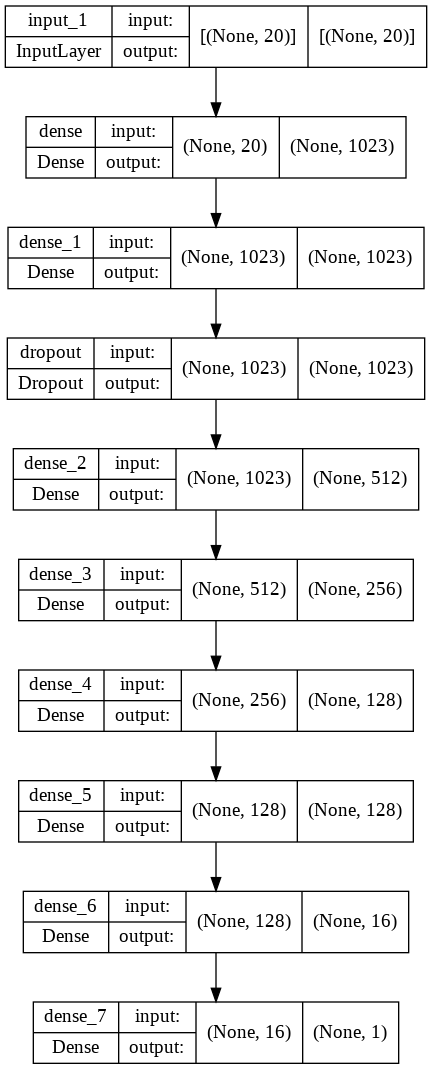

In [ ]:
#Display the simplified version of model
keras.utils.plot_model(model, "model.png", show_shapes=True)

# Result of Trained Model with Test Data

In [ ]:
#Split the data test sets, with a ratio of 
SEED=1234
x_train_val,x_test,y_train_val,y_test=train_test_split(features,final_output,
                                               test_size=0.3,random_state=SEED)
#Predict the productivity using test data
predictions= model.predict(x_test)
pred_vs_label=np.concatenate((predictions,np.expand_dims(y_test,axis=1)),axis=1)
print(pred_vs_label)

[[0.82163668 0.80088889]
 [0.70673275 0.7002366 ]
 [0.77779293 0.75034483]
 [1.00221217 0.99999524]
 [0.82352287 0.90296296]
 [0.59947515 0.271875  ]
 [0.73359865 0.80687917]
 [0.66632366 0.70006981]
 [0.62935799 0.60004068]
 [0.59757692 0.5565625 ]
 [0.71557087 0.68355061]
 [0.96776867 0.94998161]
 [0.76892722 0.79996322]
 [0.75878102 0.54979167]
 [0.70118451 0.70090357]
 [0.5307954  0.50056731]
 [0.81795412 0.97852564]
 [0.83078718 0.85041563]
 [0.68214768 0.82714744]
 [0.6785925  0.70061823]
 [0.74921536 0.75007932]
 [0.68839031 0.70018458]
 [0.87459481 0.85007069]
 [0.84811163 0.80040196]
 [0.73895508 0.92885   ]
 [0.4074381  0.35003125]
 [0.76062948 0.8000345 ]
 [0.64505374 0.60007051]
 [0.8723802  0.89911111]
 [0.4114899  0.28698457]
 [0.85414559 0.91276667]
 [0.90669048 0.899     ]
 [0.52693647 0.46319444]
 [0.85327792 0.80070175]
 [0.83657902 0.80027383]
 [0.64764231 0.91375   ]
 [0.63789922 0.6502435 ]
 [0.78192919 0.91995454]
 [0.52227461 0.47729167]
 [0.72627395 0.79000324]


Text(0.5, 1.0, 'Graph of Predicted Y vs Label')

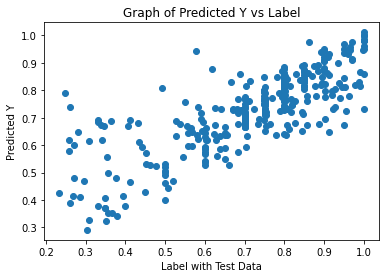

In [ ]:
#plot the graph
plt.scatter(y_test,predictions)
plt.xlabel('Label with Test Data')
plt.ylabel('Predicted Y')
plt.title('Graph of Predicted Y vs Label')

In [ ]:
#Evaluation metrics for regression 
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.07047184140818857
MSE: 0.012095794316994087
RMSE: 0.1099808815976399
